In [1]:
# Default parameters which will be overwritten by the
# actual parameters in a new cell below this one.

product_type = "SMOS-L2C-SM"  # or "SMOS-L2C-OS"
time_range = "2022-01-01/2022-01-03"
interval = "1d"  # or None or ""

In [ ]:
# This is a fixed path you can use to write the output file to.
# The data written here will end up in a unique location for every job run.
output_dir = "/home/jovyan/result-data"

In [2]:
target_path = f'smos-{time_range.replace("-", "").replace("/", "-")}-{interval.lower()}.zarr'
target_path

'smos-20220101-20220103-1d.zarr'

In [21]:
import json
import logging
import os
import shutil
from typing import Iterator

from IPython.display import JSON
import numpy as np
import pandas as pd
import xarray as xr

from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store
from zappend.api import Context
from zappend.api import SliceSource
from zappend.api import zappend
from zappend.api import to_slice_factory

In [4]:
def get_time_ranges(time_range: str, interval: str | None) -> list[tuple[str, str]]:
    one_sec = pd.Timedelta("1s")
    one_day = pd.Timedelta("1d")

    start_date, stop_date = time_range.split("/", maxsplit=1)
    interval_td = pd.Timedelta(interval) if interval else one_day
    dates = pd.date_range(start_date, stop_date, freq=interval_td)

    def to_date_str(date):
        return date.strftime("%Y-%m-%d")

    return [(to_date_str(dates[i]), to_date_str(dates[i+1] - one_sec)) 
            for i in range(len(dates) - 1)]

In [5]:
time_ranges = get_time_ranges(time_range, interval)
time_ranges

[('2022-01-01', '2022-01-01'), ('2022-01-02', '2022-01-02')]

In [6]:
with open("creodias-credentials.json") as f:
    credentials = json.load(f)

In [7]:
store = new_data_store(
    'smos', 
    source_path="s3://EODATA", 
    source_storage_options=dict(
        endpoint_url="https://s3.cloudferro.com", 
        anon=False, 
        **credentials
    ),
    cache_path="nc_cache",
    xarray_kwargs=dict(
        engine="h5netcdf"
        #engine="netcdf4"
    )
)

In [8]:
JSON(store.list_data_ids())

<IPython.core.display.JSON object>

In [9]:
class MeanSliceSource(SliceSource):
    
    def __init__(
        self, 
        ctx: Context, 
        ds_iterator: Iterator, 
        time_range: tuple[str, str]
    ):
        super().__init__(ctx)
        self.ds_iterator = ds_iterator
        self.time_range = time_range
        temp_path = f"./temp-{'-'.join(time_range)}"
        self.temp_path = temp_path
        self.slice_path = temp_path + ".zarr"   
        self.ds_mean = None
        self.logger = logging.getLogger("notebook")    
    
    def get_dataset(self) -> xr.Dataset:        
        ds_iterator = self.ds_iterator
        time_range = self.time_range
        temp_path = self.temp_path
        slice_path = self.slice_path 
        logger = self.logger        
                
        if not os.path.exists(temp_path):
            os.mkdir(temp_path)
            
        num_datasets = len(ds_iterator)
        temp_slice_paths = []
        for index, ds in enumerate(ds_iterator):
            temp_slice_path = f"{temp_path}/slice-{index}.nc"
            logger.info(f"Writing slice %d of %d to %s", 
                        index + 1, num_datasets, temp_slice_path)
            ds.to_netcdf(temp_slice_path, mode="w")
            temp_slice_paths.append(temp_slice_path)
            
        ds = xr.open_mfdataset(temp_slice_paths, 
                               combine="nested", 
                               concat_dim="time")

        ds_mean = ds.mean("time")
        
        # ds_mean has no time dimension, so we re-introduce it 
        ds_mean = ds_mean.expand_dims("time", axis=0)
        start, stop = pd.to_datetime(time_range)
        ds_mean.coords["time"] = xr.DataArray(
            np.array([start + (stop - start) / 2]), 
            dims="time", 
        )
        ds_mean.coords["time_bnds"] = xr.DataArray(
            np.array([[start, stop]]), 
            dims=("time", "bnds"),
        )
        
        # Align encoding and attributes
        for var_name, var in ds.variables.items():
            mean_var = ds_mean.get(var_name)
            if mean_var is not None:
                mean_var.encoding.update(var.encoding)
                mean_var.attrs.update(var.attrs)
            
        logger.info(f"Writing mean slice to %s", slice_path)
        ds_mean.to_zarr(slice_path, mode="w", write_empty_chunks=False)        
        ds_mean.close()
        ds_mean = None
        ds.close()
        ds = None

        logger.info(f"Removing temporary %s", temp_path)
        shutil.rmtree(temp_path, ignore_errors=True)

        self.ds_mean = xr.open_zarr(slice_path)
        return self.ds_mean
        
    def dispose(self):
        if self.ds_mean is not None:
            self.ds_mean.close()
            self.ds_mean = None        
        self.logger.info(f"Removing temporary %s", self.slice_path)
        shutil.rmtree(self.slice_path, ignore_errors=True) 

In [10]:
def generate_datasets(store, product_type, time_ranges, interval):    
    for time_range in time_ranges:        
        ds_iterator = store.open_data(
            product_type, 
            opener_id="dsiter:zarr:smos",
            time_range=time_range
        )                
        if interval is None:
            # If we have no interval, we deliver the slices as provided.
            yield from ds_iterator
        else:            
            # Otherwise we deliver a slice source that creates the 
            # mean of slices in ds_iterator.
            yield to_slice_factory(MeanSliceSource, ds_iterator, time_range)

In [11]:
# Test generate_datasets
#generator = generate_datasets(store, product_type, time_ranges, interval)
#ds_path = next(generator)
#ds_path

In [12]:
#with xr.open_dataset(ds_path) as ds:
#    display(ds)
#    display(ds.Soil_Moisture.plot.imshow())

In [13]:
zappend_config = {
    "target_dir": "./" + target_path, 
    
    "fixed_dims": {
        "lon": 8192,
        "lat": 4032
    },
    
    "append_dim": "time",
    
    "persist_mem_slices": False,
    
    "variables": {
        "*": {
            "encoding": {
                "chunks": [1, 4032 // 4, 8192 // 4]
            }
        },
        "time": {
            "encoding": {
                "chunks": [100]
            }
        },
        "time_bnds": {
            "encoding": {
                "chunks": [100, 2]
            }
        },
        "lat": {
            "encoding": {
                "chunks": [4032]
            }
        },
        "lon": {
            "encoding": {
                "chunks": [8192]
            }
        },
    },
    
    # Log to the console.
    # Note you could also configure the log output for dask here.
    "logging": {
        "version": 1,
        "formatters": {
            "normal": {
                "format": "%(asctime)s %(levelname)s %(message)s",
                "style": "%"
            }
        },
        "handlers": {
            "console": {
                "class": "logging.StreamHandler",
                "formatter": "normal"
            }
        },
        "loggers": {
            "zappend": {
                "level": "INFO",
                "handlers": ["console"]
            },
            "notebook": {
                "level": "INFO",
                "handlers": ["console"]
            },
            #"xcube-smos": {
            #    "level": "DEBUG",
            #    "handlers": ["console"]
            #}
        }
    }
}

In [14]:
generator = generate_datasets(store, product_type, time_ranges, interval)
zappend(generator, config=zappend_config)

2024-01-18 12:15:28,246 INFO Writing slice 1 of 29 to ./temp-2022-01-01-2022-01-01/slice-0.nc
2024-01-18 12:15:30,262 INFO Writing slice 2 of 29 to ./temp-2022-01-01-2022-01-01/slice-1.nc
2024-01-18 12:15:32,194 INFO Writing slice 3 of 29 to ./temp-2022-01-01-2022-01-01/slice-2.nc
2024-01-18 12:15:34,105 INFO Writing slice 4 of 29 to ./temp-2022-01-01-2022-01-01/slice-3.nc
2024-01-18 12:15:36,021 INFO Writing slice 5 of 29 to ./temp-2022-01-01-2022-01-01/slice-4.nc
2024-01-18 12:15:37,954 INFO Writing slice 6 of 29 to ./temp-2022-01-01-2022-01-01/slice-5.nc
2024-01-18 12:15:39,923 INFO Writing slice 7 of 29 to ./temp-2022-01-01-2022-01-01/slice-6.nc
2024-01-18 12:15:41,869 INFO Writing slice 8 of 29 to ./temp-2022-01-01-2022-01-01/slice-7.nc
2024-01-18 12:15:43,779 INFO Writing slice 9 of 29 to ./temp-2022-01-01-2022-01-01/slice-8.nc
2024-01-18 12:15:45,717 INFO Writing slice 10 of 29 to ./temp-2022-01-01-2022-01-01/slice-9.nc
2024-01-18 12:15:47,676 INFO Writing slice 11 of 29 to ./te

In [15]:
ds = xr.open_zarr(target_path)

In [16]:
ds

<xarray.Dataset>
Dimensions:            (time: 4, lat: 4032, lon: 8192, bnds: 2)
Coordinates:
  * lat                (lat) float64 88.57 88.53 88.48 ... -88.48 -88.53 -88.57
  * lon                (lon) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time               (time) datetime64[ns] 2022-01-01 ... 2022-01-02
    time_bnds          (time, bnds) datetime64[ns] dask.array<chunksize=(4, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    Chi_2              (time, lat, lon) float32 dask.array<chunksize=(1, 1008, 2048), meta=np.ndarray>
    Chi_2_P            (time, lat, lon) float32 dask.array<chunksize=(1, 1008, 2048), meta=np.ndarray>
    Grid_Point_ID      (time, lat, lon) float64 dask.array<chunksize=(1, 1008, 2048), meta=np.ndarray>
    N_RFI_X            (time, lat, lon) float32 dask.array<chunksize=(1, 1008, 2048), meta=np.ndarray>
    N_RFI_Y            (time, lat, lon) float32 dask.array<chunksize=(1, 1008, 2048), meta=np.ndarray>
    RFI_Prob           (time, lat, lon) float32 dask.array<chunksize=(1, 1008, 2048), meta=np.ndarray>
    Soil_Moisture      (time, lat, lon) float32 dask.array<chunksize=(1, 1008, 2048), meta=np.ndarray>
    Soil_Moisture_DQX  (time, lat, lon) float32 dask.array<chunksize=(1, 1008, 2048), meta=np.ndarray>

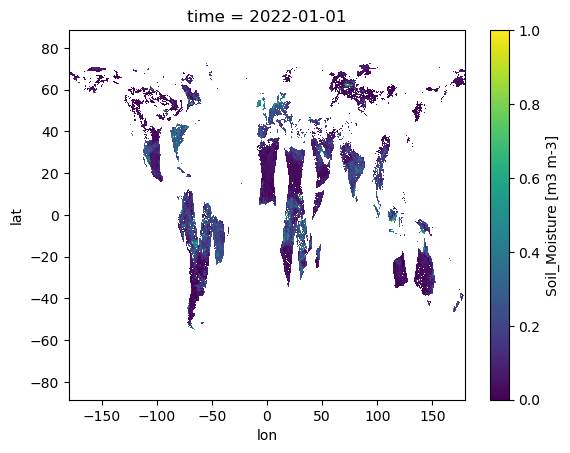

In [17]:
ds.Soil_Moisture.isel(time=0).plot.imshow()

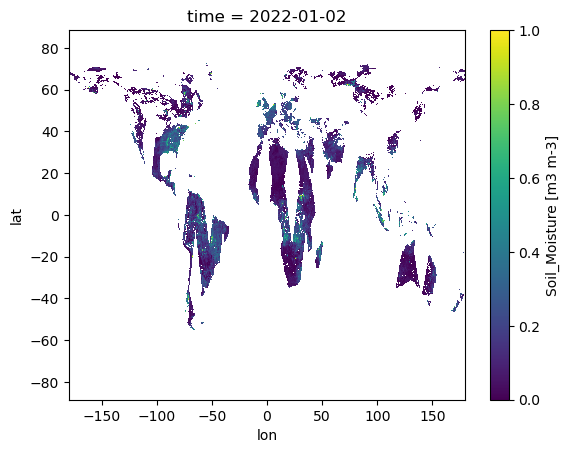

In [18]:
ds.Soil_Moisture.isel(time=1).plot.imshow()

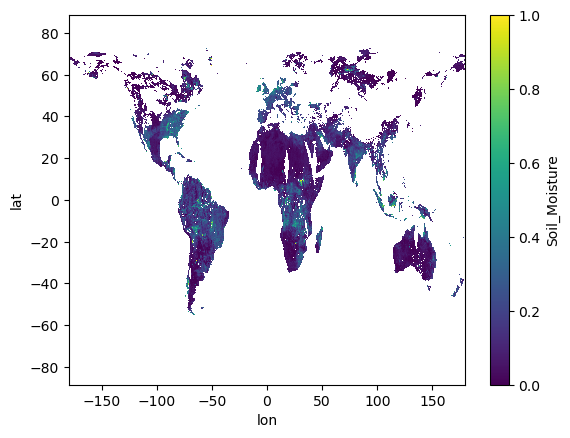

In [19]:
ds.Soil_Moisture.mean("time").plot.imshow()